# Computer Vision Model

I worked on creating a computer vision model trained to classify breast tumor histopathology images as benign or malignant, and further into 8 subtypes using deep learning (ResNet18).

### Library Imports

To start I imported all essential libraries for deep learning, data handling, image processing, and training visualization:

- `torch`, `torchvision`: model building and image transforms
- `PIL.Image`: image loading
- `pandas`, `os`: dataset and path handling
- `tqdm`: training progress bars
- `matplotlib.pyplot`: plotting metrics and evaluation visuals


In [9]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt


### About the Dataset: BreakHis

The **BreakHis** dataset contains 9,109 microscopic images of breast tumor tissue from 82 patients.

- **Resolution**: 700×460 RGB PNGs
- **Magnifications**: 40X, 100X, 200X, 400X
- **Tumor Categories**:
  - **Benign (0)**: adenosis, fibroadenoma, phyllodes tumor, tubular adenoma
  - **Malignant (1)**: ductal carcinoma, lobular carcinoma, mucinous carcinoma, papillary carcinoma
- **Split**: Train/Test based on `Folds.csv`

To start, I first organized the images into the 8 subtypes

In [10]:
class BreakHisDataset(Dataset):
    def __init__(self, csv_file, root_dir, train=True, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        if train:
            self.data_frame = self.data_frame[self.data_frame['grp'].str.lower() == "train"]
        else:
            self.data_frame = self.data_frame[self.data_frame['grp'].str.lower() == "test"]

        self.data_frame.reset_index(drop=True, inplace=True)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        filename = row['filename']

        img_path = os.path.join(self.root_dir, filename)
        image = Image.open(img_path).convert('RGB')

        # Label assignment: 0-7 based on tumor type
        lower_filename = filename.lower()
        if "adenosis" in lower_filename:
            label = 0  # Benign
        elif "fibroadenoma" in lower_filename:
            label = 1  # Benign
        elif "phyllodes_tumor" in lower_filename:
            label = 2  # Benign
        elif "tubular_adenoma" in lower_filename:
            label = 3  # Benign
        elif "ductal_carcinoma" in lower_filename:
            label = 4  # Malignant
        elif "lobular_carcinoma" in lower_filename:
            label = 5  # Malignant
        elif "mucinous_carcinoma" in lower_filename:
            label = 6  # Malignant
        elif "papillary_carcinoma" in lower_filename:
            label = 7  # Malignant
        else:
            raise ValueError(f"Cannot determine label from filename: {filename}")

        if self.transform:
            image = self.transform(image)
        return image, label


### Data Loading and Augmentation

To prepare the BreakHis dataset for training, I used image transformations and created custom data loaders to organize the training process.

Images were processed using `torchvision.transforms` to ensure consistency and compatibility with pretrained deep learning models. Each image was:
- **Resized** to 260 × 260 pixels
- **Converted** to a PyTorch tensor using `ToTensor()`
- **Normalized** using the standard ImageNet mean and standard deviation:
  - Mean: `[0.485, 0.456, 0.406]`
  - Standard Deviation: `[0.229, 0.224, 0.225]`

A custom `BreakHisDataset` class was used to load image file paths and class labels from `Folds.csv` and map tumor subtypes to integer labels for model compatibility

PyTorch `DataLoader` objects were created for both the training and validation sets:
- **Batch size** was set to 32
- **Shuffling** was enabled for the training set to improve generalization
- `num_workers=0` was used to avoid multiprocessing issues in Jupyter notebooks

In [11]:
transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_dataset = BreakHisDataset(
    csv_file='/Users/hannahhuangh/Desktop/ds3_project/Folds.csv',
    root_dir='/Users/hannahhuangh/Desktop/ds3_project/BreaKHis_v1',
    train=True,
    transform=transform
)

val_dataset = BreakHisDataset(
    csv_file='/Users/hannahhuangh/Desktop/ds3_project/Folds.csv',
    root_dir='/Users/hannahhuangh/Desktop/ds3_project/BreaKHis_v1',
    train=False,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)



### Model Setup

I loaded a pretrained ResNet18 model using ImageNet weights (`ResNet18_Weights.DEFAULT`) and moved the model to **GPU** if available to help with faster training.


In [12]:
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

model.fc = nn.Linear(model.fc.in_features, 8)

model = model.to(device)


In [13]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [14]:
def save_checkpoint(state, filename="best_model.pth.tar"):
    torch.save(state, filename)

best_val_loss = float('inf')
epochs_without_improvement = 0


## Training Time

The model was trained over 30 epochs using a standard PyTorch training loop. At each epoch, the model goes through the full training set and was then evaluated on the validation set. Progress was tracked using the `tqdm` progress bar.

### Training Procedure

1. **Forward pass**: Images are passed through the model.
2. **Loss calculation**: Computed using `CrossEntropyLoss`.
3. **Backpropagation**: Gradients are computed and used to update the model weights.
4. **Evaluation**: After each epoch, the model is evaluated on the validation set.
5. **Learning rate adjustment**: Controlled by `ReduceLROnPlateau` scheduler.
6. **Checkpointing**: The model is saved whenever validation loss improves.

### My Variables

| Variable | Description |
|----------|-------------|
| `train_losses` | List storing average training loss per epoch |
| `val_losses` | List storing average validation loss per epoch |
| `train_accuracies` | Training accuracy at the end of each epoch |
| `val_accuracies` | Validation accuracy at the end of each epoch |
| `running_loss` | Accumulates training loss for one epoch |
| `correct`, `total` | Track how many predictions were correct / total samples |
| `train_loss`, `train_acc` | Averaged loss and accuracy for training set per epoch |
| `val_loss`, `val_acc` | Averaged loss and accuracy for validation set per epoch |
| `best_val_loss` | Lowest validation loss observed so far |
| `epochs_without_improvement` | Counts how many epochs passed without improving validation loss |
| `save_checkpoint()` | Saves model weights when `val_loss` improves |

In [15]:
num_epochs = 30

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), acc=100*(correct/total))

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        print(f"Saving new best model at epoch {epoch+1}!")
        save_checkpoint({'state_dict': model.state_dict()}, filename="best_model.pth.tar")
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

Epoch [1/30] Train Loss: 0.3510 Train Acc: 0.8753 Val Loss: 0.1104 Val Acc: 0.9565
Saving new best model at epoch 1!


Epoch [2/30] Train Loss: 0.0836 Train Acc: 0.9672 Val Loss: 0.0544 Val Acc: 0.9742
Saving new best model at epoch 2!


Epoch [3/30] Train Loss: 0.0727 Train Acc: 0.9680 Val Loss: 0.0595 Val Acc: 0.9709


Epoch [4/30] Train Loss: 0.0521 Train Acc: 0.9763 Val Loss: 0.0392 Val Acc: 0.9787
Saving new best model at epoch 4!


Epoch [5/30] Train Loss: 0.0639 Train Acc: 0.9719 Val Loss: 0.0845 Val Acc: 0.9720


Epoch [6/30] Train Loss: 0.0479 Train Acc: 0.9770 Val Loss: 0.0251 Val Acc: 0.9884
Saving new best model at epoch 6!


Epoch [7/30] Train Loss: 0.0475 Train Acc: 0.9774 Val Loss: 0.0343 Val Acc: 0.9781


Epoch [8/30] Train Loss: 0.0455 Train Acc: 0.9777 Val Loss: 0.0388 Val Acc: 0.9758


Epoch [9/30] Train Loss: 0.0480 Train Acc: 0.9773 Val Loss: 0.0336 Val Acc: 0.9796


Epoch [10/30] Train Loss: 0.0383 Train Acc: 0.9803 Val Loss: 0.0219 Val Acc: 0.9816
Saving new best model at epoch 10!


Epoch [11/30] Train Loss: 0.0468 Train Acc: 0.9776 Val Loss: 0.0278 Val Acc: 0.9814


Epoch [12/30] Train Loss: 0.0436 Train Acc: 0.9786 Val Loss: 0.0363 Val Acc: 0.9773


Epoch [13/30] Train Loss: 0.0332 Train Acc: 0.9821 Val Loss: 0.0222 Val Acc: 0.9816


Epoch [14/30] Train Loss: 0.0427 Train Acc: 0.9789 Val Loss: 0.0263 Val Acc: 0.9804


Epoch [15/30] Train Loss: 0.0257 Train Acc: 0.9850 Val Loss: 0.0198 Val Acc: 0.9820
Saving new best model at epoch 15!


Epoch [16/30] Train Loss: 0.0239 Train Acc: 0.9854 Val Loss: 0.0207 Val Acc: 0.9820


Epoch [17/30] Train Loss: 0.0257 Train Acc: 0.9847 Val Loss: 0.0214 Val Acc: 0.9819


Epoch [18/30] Train Loss: 0.0278 Train Acc: 0.9838 Val Loss: 0.0206 Val Acc: 0.9817


Epoch [19/30] Train Loss: 0.0277 Train Acc: 0.9844 Val Loss: 0.0210 Val Acc: 0.9820


Epoch [20/30] Train Loss: 0.0240 Train Acc: 0.9853 Val Loss: 0.0202 Val Acc: 0.9820


Epoch [21/30] Train Loss: 0.0232 Train Acc: 0.9856 Val Loss: 0.0203 Val Acc: 0.9820


Epoch [22/30] Train Loss: 0.0235 Train Acc: 0.9856 Val Loss: 0.0205 Val Acc: 0.9820


Epoch [23/30] Train Loss: 0.0237 Train Acc: 0.9855 Val Loss: 0.0216 Val Acc: 0.9819


Epoch [24/30] Train Loss: 0.0232 Train Acc: 0.9856 Val Loss: 0.0203 Val Acc: 0.9820


Epoch [25/30] Train Loss: 0.0230 Train Acc: 0.9857 Val Loss: 0.0210 Val Acc: 0.9820


Epoch [26/30] Train Loss: 0.0230 Train Acc: 0.9857 Val Loss: 0.0204 Val Acc: 0.9820


Epoch [27/30] Train Loss: 0.0231 Train Acc: 0.9855 Val Loss: 0.0205 Val Acc: 0.9820


Epoch [28/30] Train Loss: 0.0230 Train Acc: 0.9856 Val Loss: 0.0201 Val Acc: 0.9820


Epoch [29/30] Train Loss: 0.0231 Train Acc: 0.9857 Val Loss: 0.0203 Val Acc: 0.9820


Epoch [30/30] Train Loss: 0.0229 Train Acc: 0.9857 Val Loss: 0.0201 Val Acc: 0.9820


In [16]:
torch.save(model.state_dict(), "cancer_model.pth")


In [17]:
import torch

# Load and apply the best saved model
checkpoint = torch.load("best_model.pth.tar", map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Collecting Information

Now that all the training has been complete, it is time to look at what everything means.

In [18]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


## Classification Report

After collecting predictions on the validation set, I generated a **classification report** using `sklearn.metrics.classification_report`.

This report provides detailed metrics for each of the 8 tumor subtypes:

- **Precision**: How many of the predicted labels for a class were correct
- **Recall**: How many actual samples of a class were correctly identified
- **F1-score**: Harmonic mean of precision and recall (useful for class imbalance)
- **Support**: Number of


In [19]:
from sklearn.metrics import classification_report

tumor_types = [
    "adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma",
    "ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"
]

print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=tumor_types, digits=3))


📊 Classification Report:
                     precision    recall  f1-score   support

           adenosis      1.000     1.000     1.000      1081
       fibroadenoma      1.000     1.000     1.000      1385
    phyllodes_tumor      1.000     1.000     1.000       846
    tubular_adenoma      1.000     1.000     1.000      1203
   ductal_carcinoma      1.000     0.956     0.977      5538
  lobular_carcinoma      0.830     1.000     0.907      1203
 mucinous_carcinoma      1.000     1.000     1.000      1514
papillary_carcinoma      1.000     1.000     1.000       895

           accuracy                          0.982     13665
          macro avg      0.979     0.994     0.986     13665
       weighted avg      0.985     0.982     0.983     13665



### Confusion Matrices
Below, I created two confusion matricies to compare the accuracy results based on different subgroups.

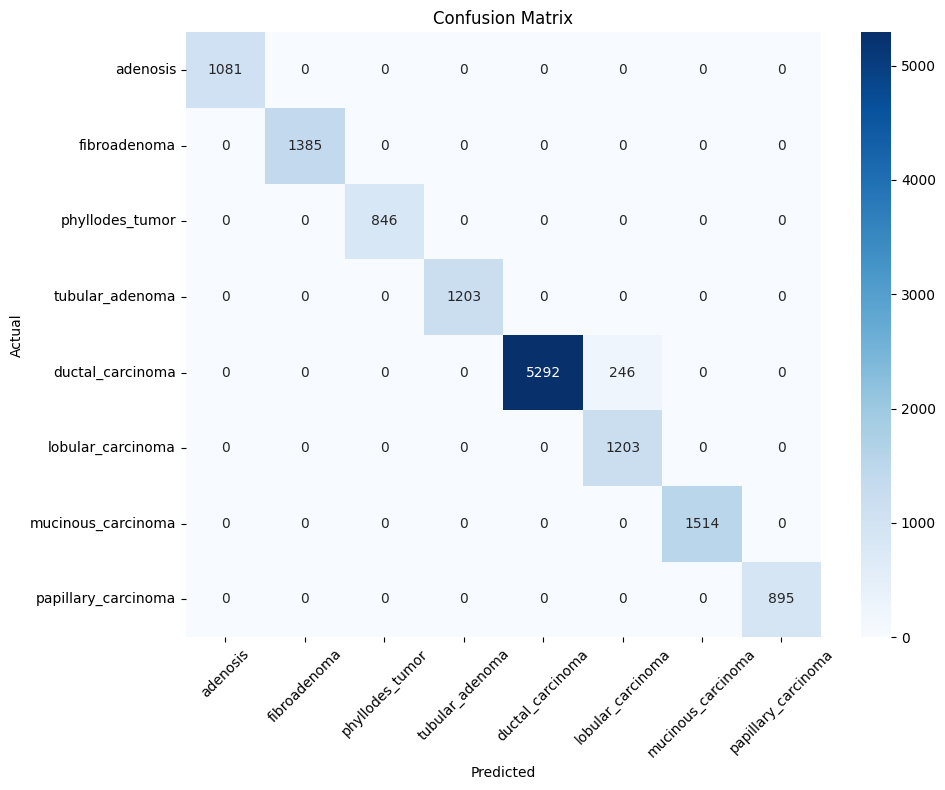

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=tumor_types, yticklabels=tumor_types)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
# Define which class indices are benign vs malignant
benign_indices = [0, 1, 2, 3]
malignant_indices = [4, 5, 6, 7]

# Convert multi-class to binary (0 = benign, 1 = malignant)
binary_labels = [0 if label in benign_indices else 1 for label in all_labels]
binary_preds = [0 if pred in benign_indices else 1 for pred in all_preds]


In [ ]:
from sklearn.metrics import confusion_matrix

binary_cm = confusion_matrix(binary_labels, binary_preds)

print("📊 Binary (Benign vs Malignant) Confusion Matrix:")
print(binary_cm)


📊 Binary (Benign vs Malignant) Confusion Matrix:
[[4515    0]
 [   0 9150]]


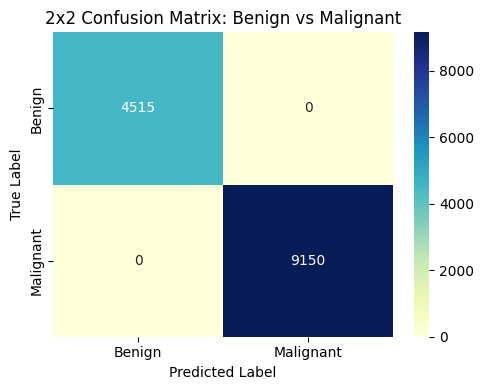

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Define tumor groupings
benign_indices = [0, 1, 2, 3]
malignant_indices = [4, 5, 6, 7]

# 2. Convert predictions and labels to binary: 0 = benign, 1 = malignant
binary_labels = [0 if label in benign_indices else 1 for label in all_labels]
binary_preds = [0 if pred in benign_indices else 1 for pred in all_preds]

# 3. Compute the 2x2 confusion matrix
binary_cm = confusion_matrix(binary_labels, binary_preds)

# 4. Plot the matrix
plt.figure(figsize=(5, 4))
sns.heatmap(binary_cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("2x2 Confusion Matrix: Benign vs Malignant")
plt.tight_layout()
plt.show()
